In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from scipy.optimize import curve_fit

In [2]:
data_path_list = [r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/hgsc-full-r2-reim/oc8-coar/ada.csv',
                  r'/Volumes/HSIT-Stallaert-Lab/data_analysis/Tyler/hgsc/data/hgsc-full-r1/oc8-coar/adavosertib.csv']

concentrations = [.00001,.001,.01,.1,.5,1,5,10]

In [3]:
base_df = pd.DataFrame(columns=['n#','cell line','drug','condition','label','area','DAPI-mean','EdU-mean','Int-DNA'])

for data_path in data_path_list:
    temp_df = pd.read_csv(data_path)
    temp_df['Int-DNA'] = temp_df['DAPI-mean']*temp_df['area']

    base_df = pd.concat([base_df,temp_df])

/var/folders/80/0dd29wb12tz3rggyy_q680gr0000gn/T/ipykernel_33209/862202972.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  base_df = pd.concat([base_df,temp_df])


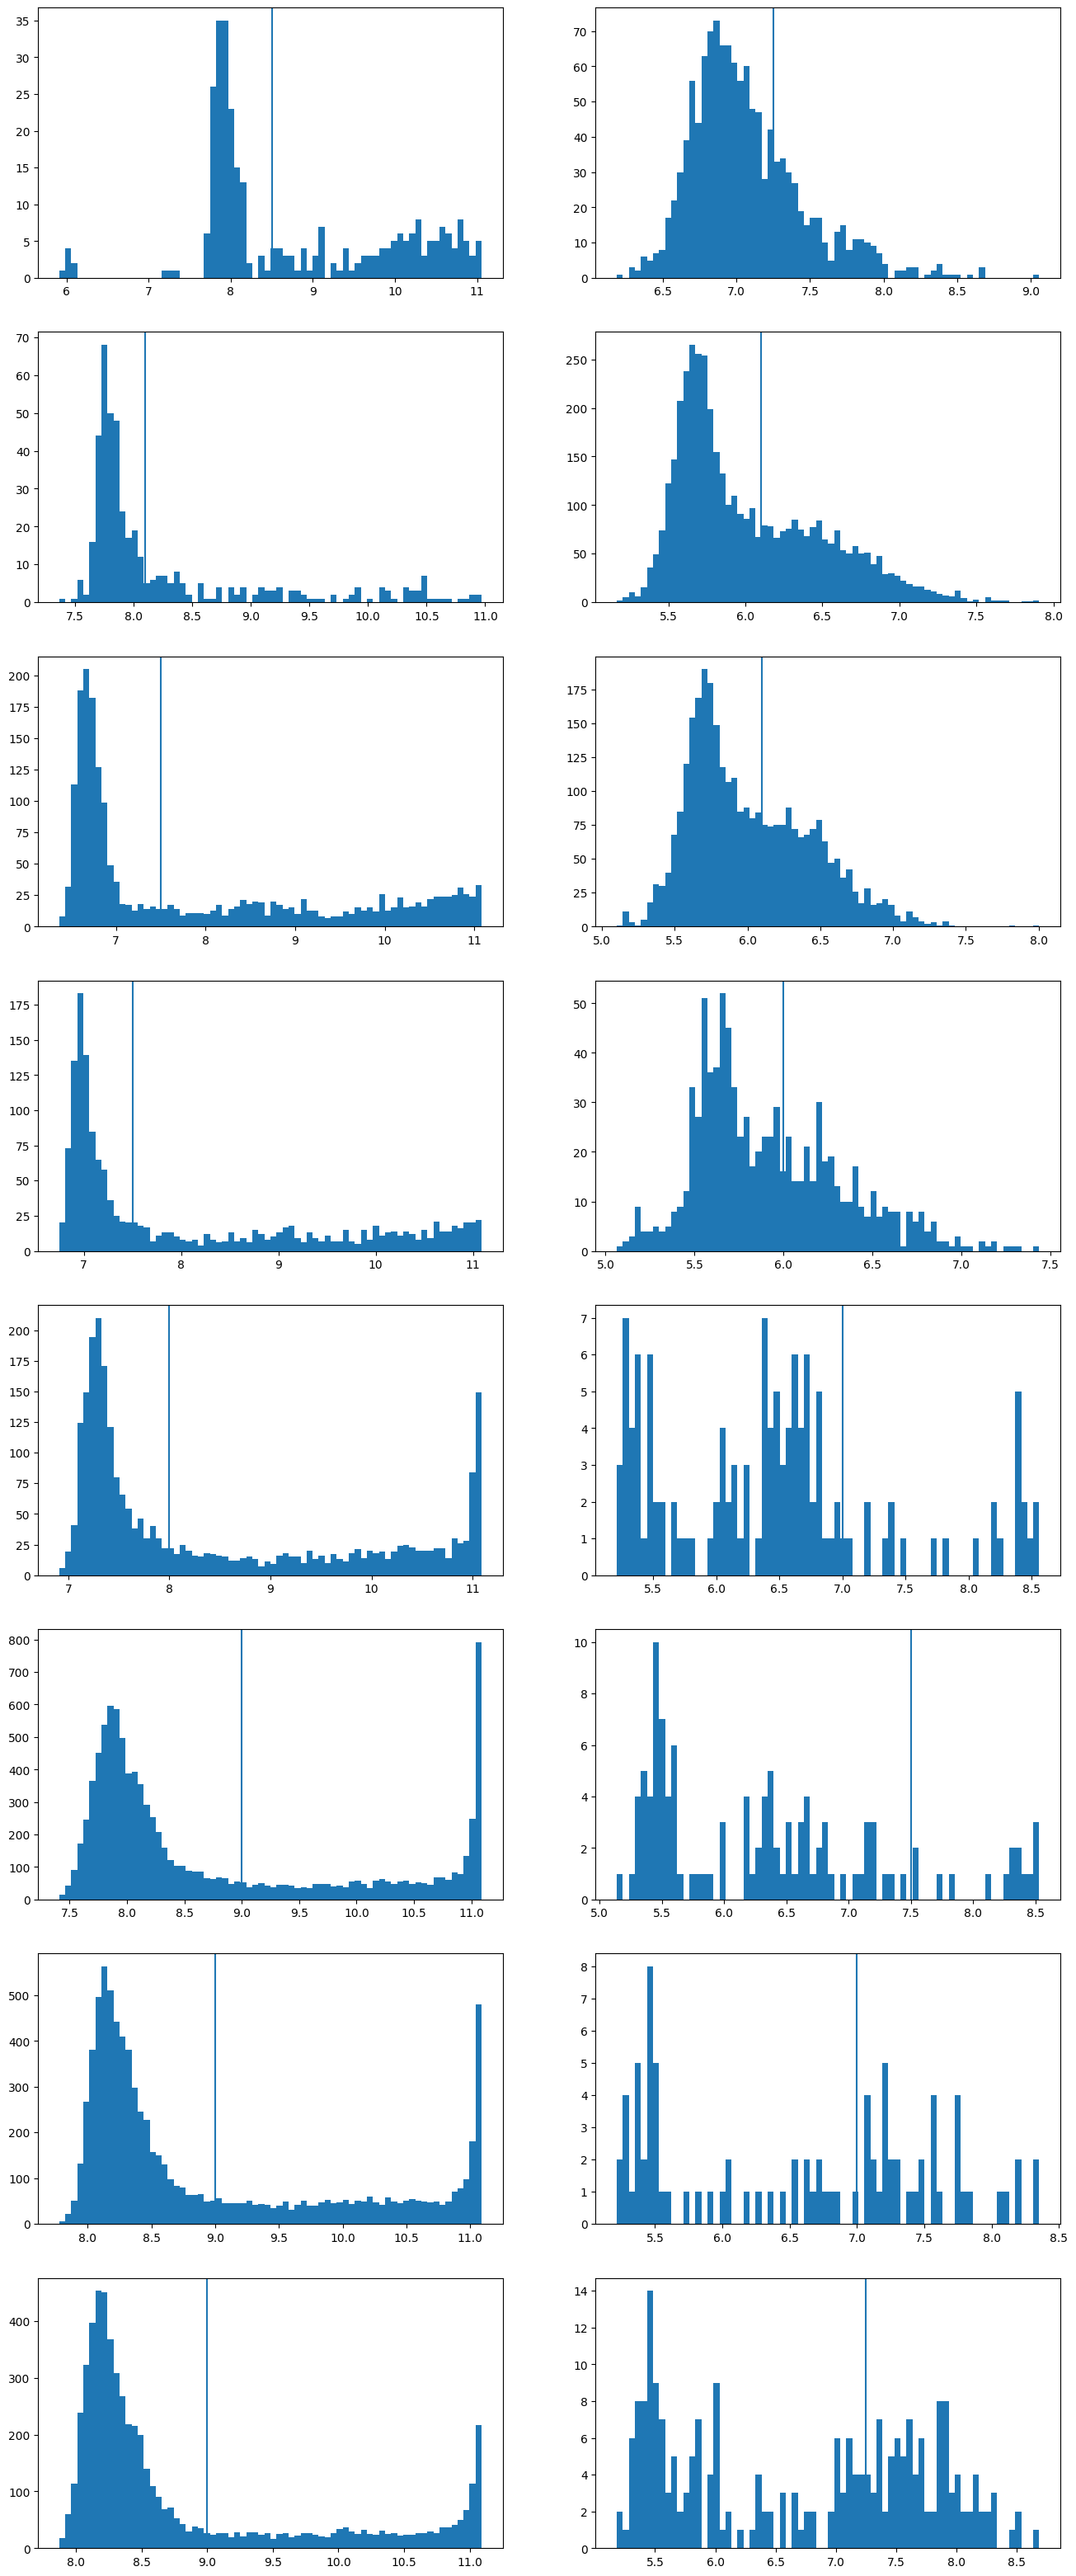

In [4]:
# EdU Positivity Graphs
fig,axs = plt.subplots(8,len(data_path_list),
                       figsize=(8*len(data_path_list),40))

threshold_list = [[8.5,8.1,7.5,7.5,8,9,9,9],
                  [7.25,6.1,6.1,6,7,7.5,7,7.25]]

pos_prop_list = []
 

for ind,cell_line in enumerate(np.unique(base_df['cell line'])):
    cell_line_df = base_df[base_df['cell line']==cell_line]
    prop_list = []

    for jind,condition in enumerate(np.unique(base_df['condition'])):
        cdf = cell_line_df[cell_line_df['condition']==condition]
        axi = axs[jind,ind]

        edu_data = cdf['EdU-mean']
        edu_log = np.log(edu_data)

        if not len(edu_data)==0: 
            thresh = threshold_list[ind][jind]

            axi.hist(edu_log,bins=70)
            axi.axvline(thresh)

            pos_df = cdf[cdf['EdU-mean'] > np.exp(thresh)]
            pos_prop = len(pos_df)/len(cdf)

            prop_list.append(pos_prop)

    #prop_norm_list = [x/prop_list[0] for x in prop_list]
    #pos_prop_list.append(prop_norm_list)

    pos_prop_list.append(prop_list)

E-Max Values: [-0.13874598808648764, -0.2388230529375804]
E-Max: -0.18878452051203404
IC-50 Values: [0.7781170029700297, 0.4059136531365314]
IC-50: 0.5920153280532805


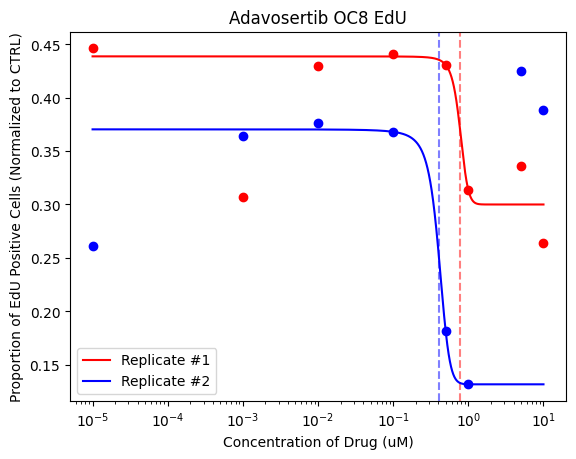

In [7]:
def sigmoid(x, a, b, c, d):
    return a / (1.0 + np.exp(-c * (x - d)))+b

to_ignore = [[1],[0,6,7]]
ic50_list = []
emax_list = []
labels = ['Replicate #1', 'Replicate #2', 'Replicate #3']
colors = ['red','blue','green']

for ind,pos_prop in enumerate(pos_prop_list):
    plt.scatter(x=concentrations,y=pos_prop,color=colors[ind])

    concentration_fin = [x for i,x in enumerate(concentrations) if i not in to_ignore[ind]]
    pos_prop_fin = [x for i,x in enumerate(pos_prop) if i not in to_ignore[ind]]

    popt,pcov = curve_fit(sigmoid,
                      concentration_fin,
                      pos_prop_fin,
                      maxfev=10000)

    x_fit = np.linspace(min(concentrations),max(concentrations),100000)
    y_fit = sigmoid(x_fit,*popt)

    half_effect = (y_fit[0]+y_fit[-1])/2
    ic50 = x_fit[(np.argmin(np.abs([x-half_effect for x in y_fit])))]
    ic50_list.append(ic50)

    plt.axvline(ic50,color=colors[ind],linestyle='--',alpha=.5)
    plt.plot(x_fit,y_fit,color=colors[ind],label=labels[ind])
    emax = y_fit[-1]-y_fit[0]
    emax_list.append(emax)
print(f'E-Max Values: {emax_list}')
print(f'E-Max: {np.average(emax_list)}')

plt.xscale('log')
plt.legend()
plt.title('Adavosertib OC8 EdU')
plt.ylabel('Proportion of EdU Positive Cells (Normalized to CTRL)')
plt.xlabel('Concentration of Drug (uM)')

print(f'IC-50 Values: {ic50_list}')
print(f'IC-50: {np.average(ic50_list)}')

In [6]:
## Death in last 2 wells skews the data to look like its increasing. its not. its just dead.